In [2]:
from sklearn.datasets import load_iris
from sklearn import tree
import pydotplus
import sys
import os       

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import datetime

os.chdir('D:/zxdf/Workspaces/PycharmProjects/flask_ml')
from app import config, Elasticsearch_Util
from app.lib import nltk_text_analyze_lib as textAnalyzer
from app.lib import sklearn_classification_lib as skclassification

os.environ["PATH"] += os.pathsep + r'D:/zxdf/software/Graphviz2.38/bin/'

starttime = datetime.datetime.now()
print ("当前的日期和时间是 %s" % starttime)

In [3]:
def getDataFromES(es_util, index, type, beginTime, endTime, fromnum, size, source_include):
    # 最大查询10000条数据
    query_data = {
        "from": fromnum,
        "size": size,
        "query": {
            "bool": {
                "must": [
                    {
                        "range": {
                            "@timestamp": {
                                "from": beginTime,
                                "to": endTime
                            }
                        }
                    }
                ],
            }
        },
        "_source": {
            "includes": source_include,
            "excludes": []
        },
        "sort": [
            {
                "@timestamp": {
                    "order": "desc"
                }
            }
        ]
    }
    res = es_util.query(index, type, query_data)
    df = None
    records = []
    for doc in res['hits']['hits']:
        records.append(doc['_source'])
    if records:
        df = pd.DataFrame(records)
    return df


In [4]:
index = "1012-knowledge_training-*"
type = "knowledge_training"
beginTime = "2018-01-19T00:00:00.000+08:00"
endTime = "2018-01-20T00:00:00.000+08:00"
fromnum = 0
size = 1608
tag = "isException"
logmsg = "logBody"
source_include = [tag, logmsg]

es_util = Elasticsearch_Util()
train_data = getDataFromES(es_util, index=index, type=type,
                           beginTime=beginTime, endTime=endTime,
                           fromnum=fromnum, size=size,
                           source_include=source_include)
feature_data_array = train_data[logmsg]
class_data_array = train_data[tag]
print len(feature_data_array)
print len(class_data_array)

# 提取特征
tf_transformer = TfidfVectorizer(tokenizer=textAnalyzer.tokenize, stop_words='english', decode_error='ignore')
feature_datas = tf_transformer.fit_transform(feature_data_array)

# 将类别转化为数字标签
#le = LabelEncoder()
#train_labelValues = le.fit_transform(class_data_array)

In [6]:
tf_transformer.get_feature_names()

[u"''",
 u"'/",
 u"'/'",
 u"'0x0",
 u"'2",
 u"'201504101118",
 u"'2017-01-12",
 u"'2459",
 u"'=",
 u"'address",
 u"'afactorybean",
 u"'application.dateformat",
 u"'application/json",
 u"'application/x-www-form-urlencoded",
 u"'autoconfigurationreportendpoint",
 u"'autoreconnect=true",
 u"'bankconfigsubtypes",
 u"'bean",
 u"'beansendpoint",
 u"'before",
 u"'bigint",
 u"'binderid",
 u"'car",
 u"'car'",
 u"'cn=",
 u"'cn=tuser08",
 u"'com.qiang.test.r",
 u"'com.vervewireless.dao.hibernate",
 u"'common/head.vm",
 u"'config",
 u"'configurationpropertiesreportendpoint",
 u"'content-length",
 u"'dan",
 u"'datasource",
 u"'datasourceinitializer",
 u"'dbo",
 u"'dc=example",
 u"'dfifilter",
 u"'dispatcherservlet",
 u"'driverclassname",
 u"'dumpendpoint",
 u"'dvega",
 u"'empdao",
 u"'employee",
 u"'en_us",
 u"'endpointhelper",
 u"'entitymanager",
 u"'entitymanagerfactory",
 u"'environmentendpoint",
 u"'errorchannel",
 u"'eventlisteners",
 u"'false",
 u"'fileuploadrequest",
 u"'getlocalhost",
 u"'h

In [5]:
 feature_datas.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05752619,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09721472,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [22]:
list(set(class_data_array))

[u'1', u'0']

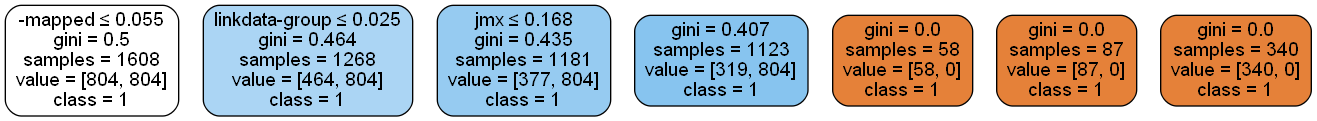

In [20]:
from IPython.display import Image  

model = DecisionTreeClassifier(max_depth=3)
model.fit(feature_datas, class_data_array)
#['target_names', 'data', 'target', 'DESCR', 'feature_names']
error_data=feature_datas
# 获取词袋模型中的所有词
error_feature_names = tf_transformer.get_feature_names()
error_target=class_data_array
#error_target_names=list(set(class_data_array))
#error_target_names=['1','0']

dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=wordlist,  
                         class_names=error_target,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 